# Pipeline de Sentimiento BiLSTM (Configuración C02)

Este notebook reproduce el flujo completo del **mejor modelo de la Fase 2** (BiLSTM + Word2Vec + limpieza básica) para clasificar sentimientos en reseñas de hoteles andaluces.

**Objetivo**: Replicar los resultados reportados (F1-macro ≈ 0.78) de manera simple y transparente.

## Agenda
1. **Configuración**: Carga de librerías y fijación de semillas (reproducibilidad).
2. **Datos**: Carga, limpieza y tokenización del texto.
3. **Embeddings**: Entrenamiento de Word2Vec sobre el corpus.
4. **Validación**: Preparación de 3 folds estratificados.
5. **Entrenamiento**: Bucle de entrenamiento del modelo BiLSTM.
6. **Evaluación**: Métricas detalladas y gráficos de desempeño.

## 1. Configuración del Entorno
Cargamos las librerías necesarias y definimos una configuración base idéntica a los scripts del proyecto (`config/phase2.yaml`).

In [1]:
import json
import os
import random
import sys
import time
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from gensim.models import Word2Vec
from sklearn.model_selection import StratifiedKFold

# Añadir ruta del proyecto para importar módulos propios
REPO_ROOT = Path("..").resolve()
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from src.data.dataset_loader import LABEL_TO_INDEX, ORIGINAL_LABELS, compute_class_weights
from src.eval.metrics import evaluate_predictions

# --- Configuración Global (Réplica de C02) ---
CONFIG = {
    "data_path": REPO_ROOT / "data/Big_AHR.csv",
    "cache_dir": REPO_ROOT / "artifacts/cache",
    "output_dir": REPO_ROOT / "artifacts/notebook_results",
    "seed": 42,
    "max_len": 256,
    "vocab_size": 30000,
    "embedding_dim": 128,
    "batch_size": 256,
    "epochs": 20,
    "learning_rate": 5e-4,
    "model_units": 64,
    "dropout": 0.2
}

# Crear directorios de salida
CONFIG["output_dir"].mkdir(parents=True, exist_ok=True)
CONFIG["cache_dir"].mkdir(parents=True, exist_ok=True)

# Fijar semillas para reproducibilidad
random.seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
tf.random.set_seed(CONFIG["seed"])
os.environ["TF_DETERMINISTIC_OPS"] = "1"

print("Configuración cargada. Usando dispositivo:", tf.config.list_physical_devices("GPU") or "CPU")

Configuración cargada. Usando dispositivo: CPU


## 2. Carga y Limpieza de Datos
Usamos una limpieza "baseline" (minúsculas + eliminar espacios extra), que resultó ser la más eficiente en nuestros experimentos previos. Usamos caché para no repetir este paso innecesariamente.

Cargando textos limpios desde caché: /Users/david/Documents/DeepLearningP2/artifacts/cache/clean_baseline.joblib


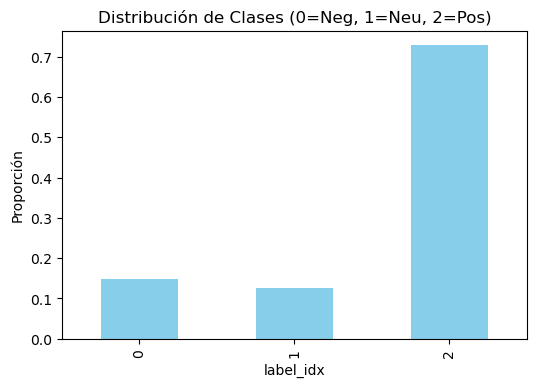

Total muestras: 18172
Ejemplo texto: un hotel muy bueno el personal fue muy amable y profesional nos gustaban desayuno mucho también el h...


In [2]:
import re

def limpiar_texto(textos):
    """Limpieza básica: minúsculas y tokenización simple por espacios."""
    limpios = []
    listas_tokens = []
    patron = re.compile(r"\b\w+\b", flags=re.UNICODE)
    
    for t in textos:
        t = str(t).lower().strip()
        tokens = patron.findall(t)
        limpios.append(" ".join(tokens))
        listas_tokens.append(tokens)
    return limpios, listas_tokens

# Cargar datos
df = pd.read_csv(CONFIG["data_path"])
df = df.dropna(subset=["review_text", "label"])

# Convertir etiquetas a índices (0, 1, 2)
df["label_idx"] = df["label"].astype(int).map(LABEL_TO_INDEX)

# Aplicar limpieza con caché
cache_path = CONFIG["cache_dir"] / "clean_baseline.joblib"
if cache_path.exists():
    print(f"Cargando textos limpios desde caché: {cache_path}")
    datos_cache = joblib.load(cache_path)
    textos_limpios = datos_cache["cleaned_texts"]
    tokens_lista = datos_cache["token_lists"]
else:
    print("Aplicando limpieza de textos...")
    textos_limpios, tokens_lista = limpiar_texto(df["review_text"].tolist())
    joblib.dump({"cleaned_texts": textos_limpios, "token_lists": tokens_lista}, cache_path)

# Visualizar distribución
plt.figure(figsize=(6, 4))
df["label_idx"].value_counts(normalize=True).sort_index().plot(kind="bar", color="skyblue")
plt.title("Distribución de Clases (0=Neg, 1=Neu, 2=Pos)")
plt.ylabel("Proporción")
plt.show()

print(f"Total muestras: {len(df)}")
print(f"Ejemplo texto: {textos_limpios[0][:100]}...")

## 3. Tokenización y Embeddings (Word2Vec)
1. Convertimos texto a secuencias numéricas (índices).
2. Entrenamos un modelo **Word2Vec** propio sobre nuestro corpus para capturar semántica específica de hoteles.
3. Creamos una matriz de embeddings para inicializar la red neuronal.

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Tokenizador Keras
tokenizer = Tokenizer(num_words=CONFIG["vocab_size"], oov_token="<OOV>")
tokenizer.fit_on_texts(textos_limpios)

# Convertir a secuencias con padding
secuencias = tokenizer.texts_to_sequences(textos_limpios)
X = pad_sequences(secuencias, maxlen=CONFIG["max_len"], padding="post", truncating="post")
y = df["label_idx"].values

# 2. Entrenar Word2Vec
print("Entrenando Word2Vec (esto puede tomar unos segundos)...")
w2v_model = Word2Vec(sentences=tokens_lista, vector_size=CONFIG["embedding_dim"], 
                     window=5, min_count=2, workers=4, epochs=10)

# 3. Crear matriz de embeddings
vocab_real = min(CONFIG["vocab_size"], len(tokenizer.word_index) + 1)
matriz_embedding = np.zeros((vocab_real, CONFIG["embedding_dim"]))

hits = 0
for palabra, i in tokenizer.word_index.items():
    if i < vocab_real and palabra in w2v_model.wv:
        matriz_embedding[i] = w2v_model.wv[palabra]
        hits += 1

print(f"Matriz de embedding creada: {matriz_embedding.shape}")
print(f"Cobertura de vocabulario: {hits/vocab_real:.1%}")

Entrenando Word2Vec (esto puede tomar unos segundos)...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Matriz de embedding creada: (30000, 128)
Cobertura de vocabulario: 69.7%


## 4. Definición del Modelo BiLSTM
Definimos la arquitectura ganadora:
- **Embedding**: Pre-cargado con pesos Word2Vec.
- **BiLSTM**: Procesa el texto en ambas direcciones para capturar contexto.
- **Dropout**: Para evitar sobreajuste.
- **Salida**: Capa densa con softmax para 3 clases.

In [4]:
def construir_modelo():
    inputs = layers.Input(shape=(CONFIG["max_len"],), dtype="int32")
    
    # Capa Embedding (congelada o entrenable, aquí la dejamos entrenable para fine-tuning)
    x = layers.Embedding(
        input_dim=vocab_real,
        output_dim=CONFIG["embedding_dim"],
        embeddings_initializer=keras.initializers.Constant(matriz_embedding),
        trainable=True,
        mask_zero=False  # False para permitir aceleración cuDNN
    )(inputs)
    
    # Capa Bidireccional LSTM
    # Optimizada para GPU: activaciones por defecto y sin dropout recurrente
    x = layers.Bidirectional(
        layers.LSTM(CONFIG["model_units"], return_sequences=False)
    )(x)
    
    # Regularización
    x = layers.Dropout(CONFIG["dropout"])(x)
    
    # Clasificación
    outputs = layers.Dense(3, activation="softmax")(x)
    
    model = keras.Model(inputs, outputs, name="BiLSTM_Sentiment")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=CONFIG["learning_rate"]),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model_test = construir_modelo()
model_test.summary()

Model: "BiLSTM_Sentiment"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 256, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,939,203 (15.03 MB)

 Trainable params: 3,939,203 (15.03 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Entrenamiento con Validación Cruzada
Entrenamos usando 3 folds estratificados para tener una evaluación robusta.
- **Class Weights**: Ajustamos pesos para manejar el desbalance de clases.
- **Callbacks**: Early Stopping (parar si no mejora) y reducción de Learning Rate.

In [5]:
resultados = []
historiales = []

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=CONFIG["seed"])

print("Iniciando validación cruzada (3 folds)...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- Fold {fold}/3 ---")
    
    # Separar datos
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Calcular pesos de clase (importante por el desbalance)
    pesos = compute_class_weights(y_train)
    # Ajuste manual opcional para clase negativa (como en el experimento original)
    if 0 in pesos: pesos[0] *= 1.2
    
    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_loss")
    ]
    
    # Entrenar
    model = construir_modelo()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=CONFIG["epochs"],
        batch_size=CONFIG["batch_size"],
        class_weight=pesos,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluar
    probs = model.predict(X_val, verbose=0)
    metrics = evaluate_predictions(y_val, probs, ["f1_macro", "recall_neg", "precision_pos"])
    
    print(f"Resultados Fold {fold}: F1={metrics['f1_macro']:.3f}, Recall Neg={metrics['recall_neg']:.3f}")
    
    resultados.append(metrics)
    historiales.append(history.history)

Iniciando validación cruzada (3 folds)...

--- Fold 1/3 ---
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 505ms/step - accuracy: 0.4903 - loss: 1.0693 - val_accuracy: 0.6126 - val_loss: 0.8953 - learning_rate: 5.0000e-04
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 542ms/step - accuracy: 0.7099 - loss: 0.8123 - val_accuracy: 0.7210 - val_loss: 0.7087 - learning_rate: 5.0000e-04
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 705ms/step - accuracy: 0.7802 - loss: 0.6665 - val_accuracy: 0.7727 - val_loss: 0.5663 - learning_rate: 5.0000e-04
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 714ms/step - accuracy: 0.7964 - loss: 0.5969 - val_accuracy: 0.8118 - val_loss: 0.4662 - learning_rate: 5.0000e-04
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 714ms/step - accuracy: 0.8184 - loss: 0.5371 - val_accuracy: 0.7998 - val_loss: 0.4891 - learning_rate: 5.0000e-04
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 707ms/step - accuracy: 0.8399 - loss: 0.4867 - val_accuracy: 0.8329 - val_loss: 0.4174 - learning_rate: 5.0000e-0

## 6. Análisis de Resultados y Gráficas
Aquí visualizamos el desempeño del modelo para confirmar su calidad.


=== Desempeño Promedio ===


,f1_macro,recall_neg,precision_pos
mean,0.771,0.842,0.960
std,0.006,0.015,0.007


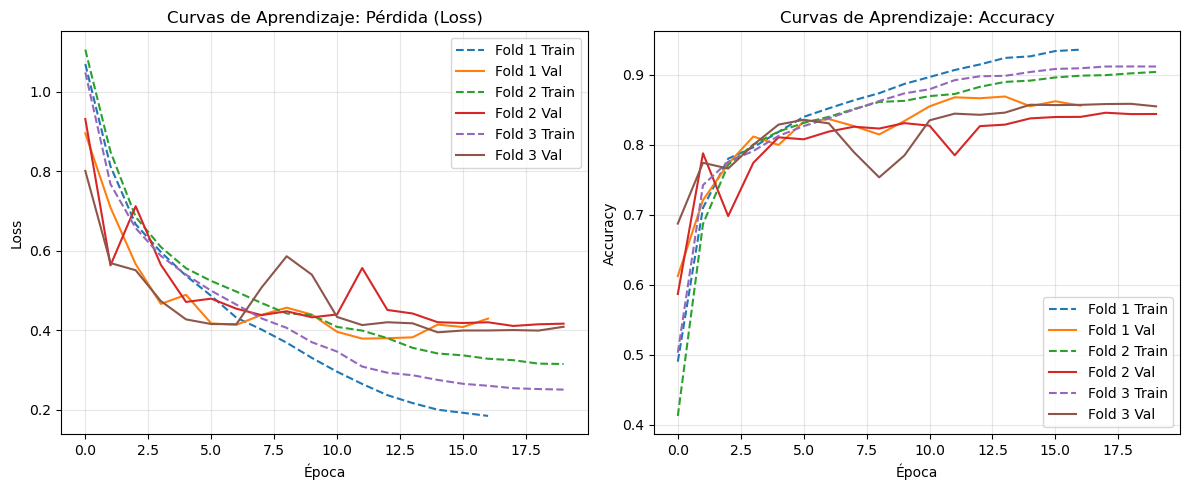


Resultados guardados en: /Users/david/Documents/DeepLearningP2/artifacts/notebook_results/resumen_final.csv


In [6]:
# 1. Tabla Resumen
df_res = pd.DataFrame(resultados)
print("\n=== Desempeño Promedio ===")
display(df_res.agg(["mean", "std"]).round(3))

# 2. Gráficas de Entrenamiento (Pérdida y Accuracy)
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
for i, h in enumerate(historiales):
    plt.plot(h['loss'], label=f'Fold {i+1} Train', linestyle='--')
    plt.plot(h['val_loss'], label=f'Fold {i+1} Val')
plt.title("Curvas de Aprendizaje: Pérdida (Loss)")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# F1 Macro (estimado indirectamente o accuracy si no está disponible en history)
plt.subplot(1, 2, 2)
for i, h in enumerate(historiales):
    if 'accuracy' in h:
        plt.plot(h['accuracy'], label=f'Fold {i+1} Train', linestyle='--')
        plt.plot(h['val_accuracy'], label=f'Fold {i+1} Val')
plt.title("Curvas de Aprendizaje: Accuracy")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Guardar resultados finales
archivo_resumen = CONFIG["output_dir"] / "resumen_final.csv"
df_res.to_csv(archivo_resumen, index_label="Fold")
print(f"\nResultados guardados en: {archivo_resumen}")